In [ ]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, RepeatVector
import matplotlib.pyplot as plt
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import random
from keras.models import Sequential
import tensorflow as tf

Mount google drive to get access to the data files and the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading in the preprocessed datasets

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/df_train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/df_test.csv")
df_val = pd.read_csv("/content/drive/MyDrive/df_val.csv")


Test if the data is loaded in properly

In [ ]:
df_train.head()

,0,1
0,why didnt i listen to you,warum habe ich dir nicht zugehört
1,ancient coins were found inside the mysterious...,in dem rätselhaften grab wurden antike münzen ...
2,he has a nice income,er hat ein gutes einkommen
3,tom is wearing a widebrimmed hat,tom trägt einen breitkrempigen hut
4,why not take a few days off,warum nehmen sie sich nicht ein paar tage frei


Convert data to lists

In [ ]:
train = df_train.values.tolist()
test = df_test.values.tolist()
val = df_val.values.tolist()

In [ ]:
train[0]

['why didnt i listen to you', 'warum habe ich dir nicht zugehört']

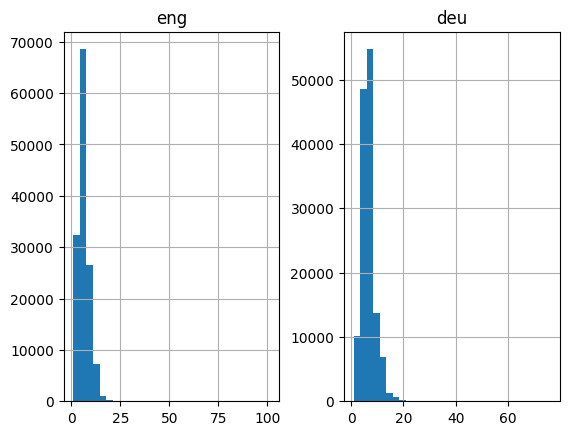

In [ ]:
en_l = []
de_l = []

for i in train:
    en_l.append(len(i[0].split()))
    de_l.append(len(i[1].split()))

length_df = pd.DataFrame({'eng': en_l, 'deu': de_l})

length_df.hist(bins=30)
plt.show()

Histograms above used to decide appropriate padding length for English and German token sequences for training. \\
By analysing the range of lengths, peak frequency, and outliers; we can see that an appropriate padding length can be around 15 to account for the normal distribution, or 10 to account for the mean. \\
This value does effect computational cost in training.

Functions below creates the tokenizer for both English and German sentences. \\
While the original model implementation had a source vocab of 6256, and a target vocab of 10329. We are using a larger vocab of 14341 for English (source) and 28493 for German (target).

function to build a tokenizer

In [ ]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

Tokenizing the English sentences

In [ ]:
en_sentences = []
for sentence in train:
    en_sentences.append(sentence[0])
en_tokenizer = tokenization(en_sentences)
en_vocab_size = len(en_tokenizer.word_index) + 1
en_length = 15 #Histogram
print('English Vocab: %d' % en_vocab_size)

English Vocab: 14341


Tokenizing the German sentences

In [ ]:
de_sentences = []
for sentence in train:
    de_sentences.append(sentence[1])
de_tokenizer = tokenization(de_sentences)
de_vocab_size = len(de_tokenizer.word_index) + 1
de_length = 15 #Hisogram
print('German Vocab: %d' % de_vocab_size)

German Vocab: 28493


Function that zero pads the sentences based on tokenizer for training

In [ ]:
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

The source sequences, or our English sentences will be encoded as X. While our target German sequences will be encoded as Y.

In [ ]:
trainX = encode_sequences(en_tokenizer, en_length, [sentence[0] for sentence in train])
trainY = encode_sequences(de_tokenizer, de_length, [sentence[1] for sentence in train])

testX = encode_sequences(en_tokenizer, en_length, [sentence[0] for sentence in test])
testY = encode_sequences(de_tokenizer, de_length, [sentence[1] for sentence in test])

valX = encode_sequences(en_tokenizer, en_length, [sentence[0] for sentence in val])
valY = encode_sequences(de_tokenizer, de_length, [sentence[1] for sentence in val])

Model Definition

In [ ]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Compile and run model

In [ ]:
model = define_model(en_vocab_size, de_vocab_size, en_length, de_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

filename = 'model.en2de_jun_13'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', save_best_only=True, mode='min')

history = model.fit(trainX,
                    trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=20, batch_size=512,
                    validation_data=(valX, valY.reshape(valY.shape[0], valY.shape[1], 1)),
                    callbacks=[checkpoint])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/267 [============================>.] - ETA: 0s - loss: 3.1049

267/267 [==============================] - 106s 378ms/step - loss: 3.1048 - val_loss: 2.7091
Epoch 2/20
266/267 [============================>.] - ETA: 0s - loss: 2.5964

267/267 [==============================] - 100s 376ms/step - loss: 2.5964 - val_loss: 2.4028
Epoch 3/20
266/267 [============================>.] - ETA: 0s - loss: 2.3329

267/267 [==============================] - 111s 417ms/step - loss: 2.3329 - val_loss: 2.2096
Epoch 4/20
267/267 [==============================] - ETA: 0s - loss: 2.1232

267/267 [==============================] - 102s 381ms/step - loss: 2.1232 - val_loss: 2.0260
Epoch 5/20
267/267 [==============================] - ETA: 0s - loss: 1.9344

267/267 [==============================] - 102s 381ms/step - loss: 1.9344 - val_loss: 1.8852
Epoch 6/20
267/267 [==============================] - ETA: 0s - loss: 1.7770

267/267 [==============================] - 111s 415ms/step - loss: 1.7770 - val_loss: 1.7760
Epoch 7/20
266/267 [============================>.] - ETA: 0s - loss: 1.6482

267/267 [==============================] - 102s 381ms/step - loss: 1.6482 - val_loss: 1.6876
Epoch 8/20
266/267 [============================>.] - ETA: 0s - loss: 1.5408

267/267 [==============================] - 102s 380ms/step - loss: 1.5409 - val_loss: 1.6165
Epoch 9/20
266/267 [============================>.] - ETA: 0s - loss: 1.4491

267/267 [==============================] - 101s 378ms/step - loss: 1.4491 - val_loss: 1.5918
Epoch 10/20
266/267 [============================>.] - ETA: 0s - loss: 1.3689

267/267 [==============================] - 102s 382ms/step - loss: 1.3689 - val_loss: 1.5087
Epoch 11/20
266/267 [============================>.] - ETA: 0s - loss: 1.2984

267/267 [==============================] - 102s 381ms/step - loss: 1.2983 - val_loss: 1.4946
Epoch 12/20
266/267 [============================>.] - ETA: 0s - loss: 1.2334

267/267 [==============================] - 111s 415ms/step - loss: 1.2334 - val_loss: 1.4641
Epoch 13/20
266/267 [============================>.] - ETA: 0s - loss: 1.1729

267/267 [==============================] - 101s 380ms/step - loss: 1.1728 - val_loss: 1.4518
Epoch 14/20
266/267 [============================>.] - ETA: 0s - loss: 1.1185

267/267 [==============================] - 101s 380ms/step - loss: 1.1184 - val_loss: 1.4280
Epoch 15/20
267/267 [==============================] - 88s 330ms/step - loss: 1.0692 - val_loss: 1.4421
Epoch 16/20
266/267 [============================>.] - ETA: 0s - loss: 1.0201

267/267 [==============================] - 101s 377ms/step - loss: 1.0201 - val_loss: 1.4165
Epoch 17/20
266/267 [============================>.] - ETA: 0s - loss: 0.9734

267/267 [==============================] - 102s 381ms/step - loss: 0.9734 - val_loss: 1.4132
Epoch 18/20
267/267 [==============================] - 88s 329ms/step - loss: 0.9302 - val_loss: 1.4133
Epoch 19/20
267/267 [==============================] - 97s 364ms/step - loss: 0.8892 - val_loss: 1.4189
Epoch 20/20
267/267 [==============================] - 88s 330ms/step - loss: 0.8492 - val_loss: 1.4240


Plots training and validation loss across epochs. \\
Loss function indicates that our model is working properly, though slightly overfitting.

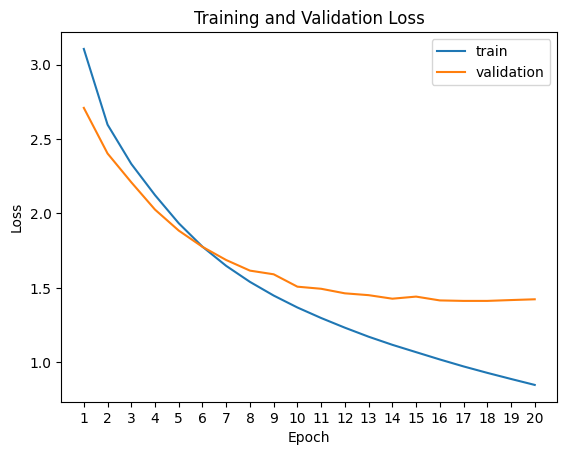

In [ ]:
plt.plot(range(1, 21), history.history['loss'])
plt.plot(range(1, 21), history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.xticks(range(1, 21))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

Functions that returns word assigned to index in tokenizer

In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

Function for saving the model

In [ ]:
tf.keras.models.save_model(model, '/content/drive/MyDrive/modelFinal/trained_model.h5', save_format='h5')

Function for zipping the model to local drive from colab notebook.



In [ ]:
'''import zipfile
from google.colab import files as colab_files
import os

# Specify the path to the folder in Google Colab
colab_folder_path = '/content/drive/MyDrive'

# Create a zip archive of the folder
zip_file_path = 'C:/Users/imaxo/Desktop/RUG FSE/Natural Language Processing/Project/modelFinal.zip'
with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(colab_folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, colab_folder_path))

# Download the zip file
colab_files.download(zip_file_path)'''

"import zipfile\nfrom google.colab import files as colab_files\nimport os\n\n# Specify the path to the folder in Google Colab\ncolab_folder_path = '/content/drive/MyDrive'\n\n# Create a zip archive of the folder\nzip_file_path = 'C:/Users/imaxo/Desktop/RUG FSE/Natural Language Processing/Project/modelFinal.zip'\nwith zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:\n    for root, dirs, files in os.walk(colab_folder_path):\n        for file in files:\n            file_path = os.path.join(root, file)\n            zipf.write(file_path, os.path.relpath(file_path, colab_folder_path))\n\n# Download the zip file\ncolab_files.download(zip_file_path)"

Functions for testing model performance on test dataset

In [ ]:
#Create subset of data to avoid memory issues
testX = testX[0:20]
testY = testY[0:20]

preds = np.argmax(model.predict(testX.reshape((testX.shape[0],testX.shape[1]))), axis=-1)

preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], de_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], de_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)

    preds_text.append(' '.join(temp))

1/1 [==============================] - 1s 1s/step


In [ ]:
initial_sentences = [sentence[0] for sentence in test[0:20]]
actual_german = [sentence[1] for sentence in test[0:20]]

pred_df = pd.DataFrame({'english': initial_sentences, 'predicted german': preds_text, 'actual german': actual_german})
pred_df

,english,predicted german,actual german
0,where is the bus,wo ist der bus,wo ist der bus
1,tom thinks it impossible for mary to break the...,tom glaubt es maria das zu,tom glaubt dass es maria unmöglich sei den rek...
2,wed better go to another room so they cant hea...,wir sollten wir noch ein nicht was können wir...,wir gehen besser in ein anderes zimmer damit n...
3,hide in the closet,froh sie den,versteck dich im schrank
4,tom asked mary to tell him about the house she...,sie ihm einem sie ein,tom bat mary ihm von dem haus zu erzählen in d...
5,tom is my flesh and blood,tom ist mein und,tom ist mein fleisch und blut
6,you are what you eat,du bist was du isst,ihr seid was ihr esst
7,shes a single mother of two,sie ist eine ihrer frau,sie ist eine alleinerziehende mutter zweier ki...
8,i am losing my patience with you,ich verliere die geduld mit geduld,ich verliere die geduld mit ihnen
9,this meeting room is small,dieses diesem ist in klein,das sitzungszimmer ist klein


Function that allows user to test model translation prediction by inputting their own sentences. \\
(Model only trained on sequences with length 15).

In [ ]:
def clean_data(text):
    text = text.replace('\n', ' ')  # remove newline
    text = text.replace('/', ' ')  # remove forward slashes
    text = re.sub(r'\s+', ' ', text)  # replace multiple whitespace with a single space
    text = re.sub(r'[^a-zA-Z0-9äöüÄÖÜß ]', '', text)  # remove non-alphanumeric characters
    text = text.lower()

    return text

In [ ]:
def predict_german_text(english_text):
    # Preprocess the English text and obtain token sequence
    english_text = clean_data(english_text)
    input_sequence = encode_sequences(en_tokenizer, en_length, [english_text])

    #Multiclassification prediction
    preds = np.argmax(model.predict(input_sequence.reshape((input_sequence.shape[0], input_sequence.shape[1]))), axis=-1)

    preds_text = []
    for i in preds:
        temp = []
        for j in range(len(i)):
            t = get_word(i[j], de_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], de_tokenizer)) or (t == None):
                    temp.append('')
                else:
                    temp.append(t)
            else:
                if(t == None):
                    temp.append('')
                else:
                    temp.append(t)

        preds_text.append(' '.join(temp))

    return preds_text[0]


english_input = input("Enter English Text Here: ", )
predicted_german = predict_german_text(english_input)
print("Predicted German Translation: ", predicted_german)


Enter English Text Here: German is too difficult
1/1 [==============================] - 0s 22ms/step
Predicted German Translation:  lustig ist zu schwer           


In [ ]:
compression_opts = dict(method='zip',
                        archive_name='results.csv')
pred_df.to_csv('results.zip', index=False,
          compression=compression_opts)